## Semi Supervised Leanring GAN for Image Classfication/Recognize Outliers (Keras version)

In [1]:
import csv
import numpy as np
import h5py
import matplotlib.pyplot as plt
import time

### 1. Read input from h5py
- ** Input: image dataset with shape $( m, IMSIZE, IMSIZE, 3)$ **
    - $m$: number of traing examples
    - IMSIZE: image width or highth, here is 64 (normally 64, 128, 256)
    - 3: color channel RGB
- $n_x$ : $n_x = IMSIZE*IMSIZE*3$: number of features of single training example, where $IMSIZE = 64$

In [453]:
f = h5py.File('data.h5','r')
#X_train = h5f['wipehero_outside_front_12330'][:]
#group = f['outside_front_50']
# group = f['outside_front_100']
# X_train = group['X'][:]
# Y_train = group['Y'][:]
group = f['outside_front_1000']
X_train = group['X_train'][:]
Y_train = group['Y_train'][:]
X_test = group['X_test'][:]
Y_test = group['Y_test'][:]
f.close()
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

((800, 64, 64, 3), (800,), (200, 64, 64, 3), (200,))


#### 1.2. CONSTANTS DEFINING THE MODEL ####

In [454]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]

m = X_train.shape[0]                 # number of training examples
n_x = img_width * img_height *3      # num_px * num_px * 3 

print("%d trainging examples. \nEach example contain %d input features." % (m, n_x))
print("Training labels shape:" + str(Y_train.shape))
print("Image_width:"+ str(img_width) + " Image_height:" + str(img_height) + " Image_depth:" + str(img_depth))

800 trainging examples. 
Each example contain 12288 input features.
Training labels shape:(800,)
Image_width:64 Image_height:64 Image_depth:3


#### 1.3. Display randomly 36 images from dataset

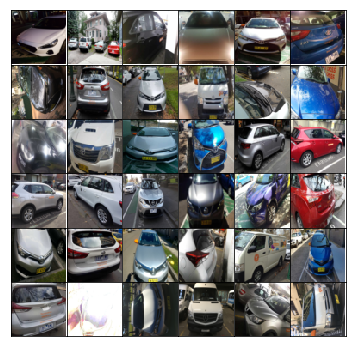

In [455]:
idx = np.random.randint(0, m, size = 36)
fig, axes = plt.subplots(6, 6, sharex = True, sharey = True, figsize = (6,6),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(X_train[ii,:,:,:], aspect ='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### 2. Preporessing data

In [456]:
print("original X_train shape:" + str(X_train.shape))
#print("original X_train:" + str(X_train))

original X_train shape:(800, 64, 64, 3)


In [457]:
# Flatten the training example data. (m: # data features, nx:# data)
#x_flatten = X_train.reshape(n_x, -1).T # The "-1" makes reshape flatten the remaining dimensions

# Scale image vectors to feature range (-1,1)
#x_train = (x_flatten.astype(np.float32) - 127.5) / 127.5
x_train = (X_train.astype(np.float32) - 127.5) / 127.5
x_test = (X_test.astype(np.float32) - 127.5) / 127.5
# Standardize/Normalize image vectors to feature values (0,1).
#X_train_n = x_flatten/255.     

y_train = Y_train.reshape(-1, 1)   # reshape to (m,1)
y_test = Y_test.reshape(-1, 1)   # reshape to (m,1)

print("Minimum value of x_train: " + str(np.min(x_train)) + "\nMaximum value of x_train: " + str(np.max(x_train)))
print("x_train shape:" + str(x_train.shape) + "\ny_train shape:" + str(y_train.shape))
print("x_test shape:" + str(x_test.shape) + "\ny_test shape:" + str(y_test.shape))


Minimum value of x_train: -1.0
Maximum value of x_train: 1.0
x_train shape:(800, 64, 64, 3)
y_train shape:(800, 1)
x_test shape:(200, 64, 64, 3)
y_test shape:(200, 1)


### 3. Build Self-defined Support function: 
### 3.1. Calculate elapsed time

In [10]:
# input: sec = end_time - start_time
def elapsed_time(sec):
    msg = ""
    if sec < 60:
        msg = str(sec) + "sec"
    elif sec < 60*60:
        msg = str(sec / 60) + "min"
    else:
        msg = str(sec / (60*60)) + "hour"
    print("Elapsed " + msg)

### 3.2. Calculate Classifier Accuray Without Considering Data Predicted as $Class$ $2:$$FAKE$

In [493]:
from numpy import argmax

def calculate_data_accuracy_without_fake (classes_with_fake, y_test):
    cnt = 0      # count the number of non-fake data
    correct = 0  # count the number of correctly labeled data
    for i in range(len(classes_with_fake)):
        label = argmax(classes_with_fake[i]) # convert one-hot category to label
        if label != 2: 
            cnt = cnt + 1
            if y_test[i] == label:
                correct = correct + 1
    acc = "Accuracy of true data: %.2f%%" % (100*float(correct) / cnt)
    return acc  

## Build SGAN
- Part1
    - Build Generator 
    - Build Discriminator
- Part2 Build GAN Model
    - Build Discriminative Model (DM) (the police)
    - Build Adversarial Model (AM) or Generator-Discriminator (the counterfeiter learning from the police).

- Part3 - Training

[keras](https://keras.io/) is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano.

In [11]:
from keras.models import Sequential
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
#from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam, RMSprop
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

from PIL import Image
import math
import argparse

Using TensorFlow backend.


### Generator
- Layer 1: Fully connected layer with $1024*4*4$ hidden units
    - input_shape: 100-dimensional vectors; output_shape: (4,4,1024); 
    - Batch Normalization: normalize Z_[l-1]; Activation: ReLU; Regularization: Dropout. 
    - Upsampling.

- Layer 2: Convolutional layer with 512 filters: 
    - input_shape (4,4,1024); output_shape (4,4, 512); 
    - activation: ReLU. 
    - Upsampling.

- Layer 3: Convolutional layer with 256 filters (output image depth = 256): 
    - input_shape (4,4, 512); output_shape (4,4,256); 
    - activation: ReLU. 
    - Do Upsampling.

- Layer 4: Convolutional layer with 128 filters (output image depth = 128): 
    - input_shape (4,4, 256); output_shape (4,4,128); 
    - activation: ReLU. 
    - Do Upsampling.

- Layer 5: Convolutional layer with 3 filters (output image depth = 3):
    - input_shape (4,4, 128); output_shape (4,4,3);
    - activation: Tanh 

In [458]:
def generator_model():
    FILTERS = 1024
    g_model = Sequential()
    
    # Layer 1: Fully connected layer
    # with input_shape (100,): 100-dimensional vectors; output_shape:(4,4,1024)
    g_model.add(Dense(FILTERS*4*4, activation="relu", input_dim=100))
    g_model.add(BatchNormalization(momentum=0.8))
    g_model.add(Reshape((4,4,FILTERS)))
    g_model.add(Dropout(0.3))   # add dropout
    g_model.add(UpSampling2D())
    # Layer 2: input_shape (4,4,1024), output_shape (4,4, 512)
    g_model.add(Conv2D(FILTERS/2, kernel_size=3, padding="same")) # filters = 1024/2=512
    g_model.add(BatchNormalization(momentum=0.8)) # BN
    g_model.add(Activation("relu"))
    g_model.add(UpSampling2D())
    # Layer 3: input_shape (4,4,512), output_shape (4,4,256)
    g_model.add(Conv2D(FILTERS/4, kernel_size=3, padding="same")) # filters = 1024/4=256
    g_model.add(BatchNormalization(momentum=0.8)) # BN
    g_model.add(Activation("relu"))
    g_model.add(UpSampling2D())
    # Layer 4: input_shape (4,4,256), output_shape (4,4,128)
    g_model.add(Conv2D(FILTERS/8, kernel_size=3, padding="same")) # filters = 1024/8=128
    g_model.add(BatchNormalization(momentum=0.8)) # BN
    g_model.add(Activation("relu"))
    g_model.add(UpSampling2D())
    # Layer 5: input_shape (4,4,128), output_shape (4,4,3)
    g_model.add(Conv2D(3, kernel_size=3, padding="same")) # filters = 3
    g_model.add(Activation("tanh"))
    
    g_model.summary()
    
    noise = Input(shape = (100,)) # This returns a tensor
    image = g_model(noise)        # model can be treat as layer, can be called on a tensor
    
    # This creates a model that includes
    # the Input layer and (1 Dense + 4 Conv) layers
    generator = Model(noise, image) # Model with input = noise, output = image
    return generator

### Discriminiator/Classfier Model
- Layer 1: Conv2D with 64 filters 
- Layer 2: Conv2D with 128 filters
- Layer 3: Conv2D with 256 filters
- Layer 4: Conv2D with 512 filters
- Flatten 
- Output Layer 1 - Binary_Dense: Fully connected layer with 1 hidden units (sigmoid)
- Output Layer 2 - Classes_Dense: Fully connected layer with (2+1) hidden units (softmax)

In [459]:
def discriminator_model(num_classes):
    image_shape = (img_width, img_height, img_depth)
    
    d_model = Sequential()
    # Layer 1: input shape: (64,64,3) output shape:(32,32,64)
    d_model.add(Conv2D(64, kernel_size=5, strides=2, input_shape=image_shape, padding="same"))
    d_model.add(LeakyReLU(alpha=0.2))
    d_model.add(Dropout(0.45)) # 1st try: 0.25, 2nd try 0.45
    # Layer 2: input shape: (32,32,64) output shape:(17, 17, 128) 
    d_model.add(Conv2D(128, kernel_size=5, strides=2,padding="same")) # output shape: (16, 16, 128)
    d_model.add(ZeroPadding2D(padding=((0,1),(0,1))))                 # output shape: (17, 17, 128) 
    d_model.add(BatchNormalization(momentum=0.8))
    d_model.add(LeakyReLU(alpha=0.2))
    d_model.add(Dropout(0.45))
    # Layer 3: input shape: (17, 17, 128)  output shape:(9,9,256)
    d_model.add(Conv2D(256, kernel_size=5, strides=2,padding="same"))
    d_model.add(BatchNormalization(momentum=0.8))
    d_model.add(LeakyReLU(alpha=0.2))
    d_model.add(Dropout(0.45))
    # Layer 4: input shape: (9,9,256)  output shape:(5, 5, 512)
    d_model.add(Conv2D(512, kernel_size=5, strides=2,padding="same"))
    d_model.add(BatchNormalization(momentum=0.8))
    d_model.add(LeakyReLU(alpha=0.2))
    d_model.add(Dropout(0.45))
    
    # Flatten shape to one dimensional, transition to FC
    d_model.add(Flatten())
    d_model.summary()
    
    image = Input(shape = image_shape)
    features = d_model(image)
    
    # Creating two output layers
    # 1. 1 Fully Connected Layer with 1 hidden unit and input: features
    # sigmoid: for binary classes
    valid = Dense(1, activation ="sigmoid", name = "Binary_Dense")(features)
    # 2. 1 Fully Connected Layer with 2+1 hidden units and input: features
    # softmax: for mutiple classes
    label = Dense(num_classes+1, activation="softmax", name = "Classes_Dense")(features)
    
    # Multi-output model: input = img, outputs =[valid, label]
    # valid: main_output
    # label: auxiliary_output
    discriminator = Model(image, [valid, label])
    return discriminator

### SGAN Class with self-defined train function

In [460]:
class SGAN():
    def __init__(self, learning_rate = 0.0004):
        
        # To keep track of loss, accuracy
        self.dis_loss, self.gen_loss, self.sgan_loss = [], [], []
        self.dis_loss_real, self.dis_loss_fake = [], []
        self.d_binary_loss, self.d_binary_acc = [], []
        self.d_classes_loss, self.d_classes_acc = [], []
        self.epoches_list = []
        
        # Initialization
        self.numClassess = 2               # 2 classes: normal (0), outlier (1)
        # Optimizer Adam: with default value: lr = 0.001, beta_1 = 0.9, beta_2=0.999, epsilon=1e-08, decay=0.0
        d_optimizer = Adam(lr=learning_rate*0.5, beta_1=0.5) 
        g_optimizer = Adam(lr=learning_rate, beta_1=0.5)
        optimizer = Adam(lr=learning_rate, beta_1=0.5)
        
        # 1. Build and compile the discriminator/classfier
        print("1.Build and compile the discriminator")
        self.discriminator = discriminator_model(self.numClassess)
        self.discriminator.compile(loss = ['binary_crossentropy', 'categorical_crossentropy'],
                             loss_weights = [0.5, 0.5],  # assign a weight of 0.5 to the label(auxiliary_output) loss, weight 0.5 to valid (main_output) loss
                             optimizer = d_optimizer,
                             metrics = ['accuracy'])
        
        # 2. Build and compile the generator
        print("2.Build and compile the generator")
        self.generator = generator_model()
        self.generator.compile(loss=['binary_crossentropy'], optimizer=g_optimizer) #optimizer=optimizer
    
    
        # 3. Combined Model: stacked generator and discriminator
        # 3.1. The generator takes noise as input and generates images
        noise = Input(shape=(100,))
        image = self.generator(noise)
        # 3.2. Only train generator in combined model, not train discriminator
        self.discriminator.trainable = False
        # 3.3. The valid takes generated images as input and determines validity
        valid, _ = self.discriminator(image)
        # 3.4. combined model: noise => generates images => determine validity
        self.combinded_model = Model(noise, valid)
        self.combinded_model.compile(loss=['binary_crossentropy'], optimizer=optimizer)
        

    def train(self, X_train, y_train, epochs = 500, batch_size=32, save_interval=50):
        # X_train: range from -1 to 1
        # y_train: shape (-1, 1) where -1 represent the number of examples
    
        half_batch = int(batch_size/2)
    
        # Class weights initialization:
        # To balance the difference in occurences of classes labels. 
        # 50% of labels that the discriminator trains on are 'fake'.
        # Weight = 1 / frequency
        cw1 = {0: 1, 1: 1}
        cw2 = {i: self.numClassess / float(half_batch) for i in range(self.numClassess)}
        cw2[self.numClassess] = 1 / float(half_batch)
        print("Class weights initialization: \nDiscriminator: 1.Real=%f, 2.Fake=%f \nClassifier: 1.Normal Cars=%f, 2.Outliers=%f, 3.Fake=%f" %
                (cw1[0],cw1[1], cw2[0], cw2[1], cw2[2]))
        
        for epoch in range(epochs):
            #--------------------------------
            # Train Discrimator
            #--------------------------------
            # Select a random half batch of images： size = half_batch
            idx = np.random.randint(0, X_train.shape[0], half_batch) # 16 random integer in range (0,m).
            images = X_train[idx]  # X_train[idx,:,:,:] get 16 train examples
        
            # Generate a random half batch of images from noise
            noise = np.random.normal(0, 1, (half_batch, 100))
            generated_images = self.generator.predict(noise)
        
            valid = np.ones((half_batch, 1)) # all 1 vectors with shape(half_batch,1)
            fake = np.zeros((half_batch, 1)) # all 0 vectors with shape(half_batch,1)
        
            # Convert labels to categorical one-hot encoding： one_hot_labels
            labels = to_categorical(y_train[idx], num_classes = self.numClassess+1)
            fake_labels = to_categorical(np.full((half_batch, 1), self.numClassess), num_classes = self.numClassess+1)
        
            # Train the discriminator/classfier by calculating loss value of D. 
            d_loss_real = self.discriminator.train_on_batch(images, [valid, labels], class_weight=[cw1, cw2])
            d_loss_fake = self.discriminator.train_on_batch(generated_images, [fake, fake_labels], class_weight=[cw1, cw2])
            self.dis_loss_real.append(d_loss_real[0])
            self.dis_loss_fake.append(d_loss_fake[0])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            #------------------------------------------------
            # Train Generator by fixing Discriminator
            #------------------------------------------------
            noise = np.random.normal(0, 1, (batch_size, 100))   # Sample noise with shape (batch_size, 100)
            validity = np.ones((batch_size, 1))                 # all 1 vectors with shape(64,1)
        
            # Train the generator by calculating the loss value of G
            g_loss = self.combinded_model.train_on_batch(noise, validity, class_weight=[cw1, cw2])
            
            # SGAN Loss
            SGAN_loss = 0.5 * (d_loss[0] + g_loss)
            
            # Keep track of the loss, accuracy
            # d_loss[0]: loss
            # d_loss[1]: Binary_Dense_loss, d_loss[3]: Binary_Dense_acc
            # d_loss[2]: Classes_Dense_loss, d_loss[4]: Classes_Dense_acc
            self.dis_loss.append(d_loss[0])
            self.gen_loss.append(g_loss)
            self.sgan_loss.append(SGAN_loss)
            self.d_binary_loss.append(d_loss[1])
            self.d_binary_acc.append(100*d_loss[3])
            self.d_classes_loss.append(d_loss[2]) 
            self.d_classes_acc.append(100*d_loss[4])
            self.epoches_list.append(epoch)
            
            if epoch % 50 == 0:
                # Plot the progress
                print ("Epoch %d: [Discriminator/Classifier loss: %f, Discriminator_acc: %.2f%%, Classifier_acc: %.2f%%] [Generator loss: %f]" %
                       (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss))
                               
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                #self.plot_images(save2file=True, samples=noise_input.shape[0],noise=noise_input, step=(i+1))
        # Save model
        self.save_model()
       
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1

        fig, axs = plt.subplots(r, c)
        count = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[count,:,:,0], cmap='gray') #, cmap='gray'
                axs[i,j].axis('off')
                count += 1
        fig.savefig("generated_images/outsideFront_%d.png" % epoch)
        plt.close()
    
    def save_model(self):
        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path, 
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "sgan_generator")
        save(self.discriminator, "sgan_discriminator")
        save(self.combinded_model, "sgan_combinded_model")

### Plot Function: Plot loss and accuracy figures

In [436]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 3.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def plot(epoches, x, d_loss, d_loss_real, d_loss_fake, g_loss, SGAN_loss, d_binary_acc, d_classes_acc):
    plt.figure(1) # plot with various axes scales
    
    # d_loss
    plt.subplot(2,1, 1)
    plt.plot(x, d_loss)
    plt.ylabel('d_loss')
    plt.xlabel('epochs')
    #plt.title("Discriminator/Classifier loss")
    plt.grid(True)
    
    # g_loss
    plt.subplot(2,1, 2)
    plt.plot(x, g_loss)
    plt.ylabel('g_loss')
    plt.xlabel('epochs')
    #plt.title("Generator loss")
    plt.grid(True)
    
    plt.figure(2) # plot with various axes scales
    
    # d_loss_real
    plt.subplot(2,1, 1)
    plt.plot(x, d_loss_real)
    plt.ylabel('d_loss_real')
    plt.xlabel('epochs')
    plt.grid(True)
    
    # d_loss_fake
    plt.subplot(2,1, 2)
    plt.plot(x, d_loss_fake)
    plt.ylabel('d_loss_fake')
    plt.xlabel('epochs')
    plt.grid(True)
    
    plt.figure(3) # plot with various axes scales
    # Binary acc
    plt.subplot(2,1,1)
    plt.plot(x, d_binary_acc, label = 'Binary Classfier Accuracy' , alpha = 0.5)
    #plt.plot(x, d_classes_acc, label = 'Multi-class Classfier Accuracy' , alpha = 0.5 )
    plt.xlabel('epochs')
    plt.ylabel('accuracy(%)')
    plt.title("Discriminator/Classifier Accuracy")
    plt.grid(True)
    plt.legend()
    
    #plt.figure(3) # plot with various axes scales
    # Binary acc
    plt.subplot(2,1,2)
    #plt.plot(x, d_binary_acc, label = 'Binary Classfier Accuracy' , alpha = 0.5)
    plt.plot(x, d_classes_acc, label = 'Multi-class Classfier Accuracy' , alpha = 0.5 )
    plt.xlabel('epochs')
    plt.ylabel('accuracy(%)')
    plt.title("Discriminator/Classifier Accuracy")
    plt.grid(True)
    
    plt.subplots_adjust(hspace=0.8)
    plt.tight_layout()
    plt.legend()
    plt.show()

### Experiment test 1: SGAN epoches 500, 100 Labelled examples
- Setting
    - leraning rate:0.0002 (D_loss converges to 0 very quickly, and loss increase. Not a good option)
    - G, D, G&D use same optimizer (**Same Learning Rate for G, D, Combined network**)
    - optimizer: Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-08, decay=0.0)
- Result Analysis: not good
    - d_loss_real: the loss of true data classfier notreducing well, strongly vibrating.

In [309]:
import timeit

sgan = SGAN(learning_rate = 0.0002)
start = timeit.default_timer()
sgan.train(x_train, y_train, epochs=500, batch_size=64, save_interval=50)
end = timeit.default_timer()

1.Build and compile the discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_265 (Conv2D)          (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_137 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_154 (Dropout)        (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_266 (Conv2D)          (None, 16, 16, 128)       204928    
_________________________________________________________________
zero_padding2d_35 (ZeroPaddi (None, 17, 17, 128)       0         
_________________________________________________________________
batch_normalization_231 (Bat (None, 17, 17, 128)       512       
_________________________________________________________________
leaky_re_lu_138 (LeakyReLU)  (None, 17

In [310]:
elapsed = elapsed_time(end-start)
#print(elapsed)

Elapsed 1.85478672557hour


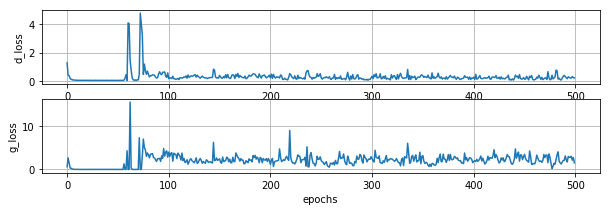

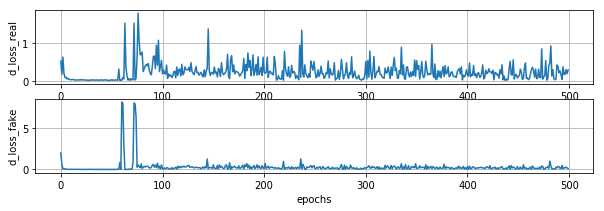

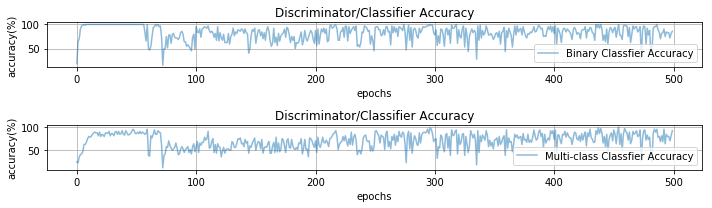

In [437]:
plot(500, sgan.epoches_list, sgan.dis_loss, sgan.dis_loss_real,sgan.dis_loss_fake, sgan.gen_loss, sgan.sgan_loss, sgan.d_binary_acc, sgan.d_classes_acc)

### Experiment test 2: 10.18- SGAN epoches 500
- Learning Rate:
    - D network: 0.0002
    - G network: 0.0004
    - Combined network: 0.0004

In [317]:
sgan2 = SGAN(learning_rate = 0.0004)
sgan2.train(x_train, y_train, epochs=500, batch_size=64, save_interval=50)

1.Build and compile the discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_273 (Conv2D)          (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_141 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_159 (Dropout)        (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_274 (Conv2D)          (None, 16, 16, 128)       204928    
_________________________________________________________________
zero_padding2d_36 (ZeroPaddi (None, 17, 17, 128)       0         
_________________________________________________________________
batch_normalization_238 (Bat (None, 17, 17, 128)       512       
_________________________________________________________________
leaky_re_lu_142 (LeakyReLU)  (None, 17

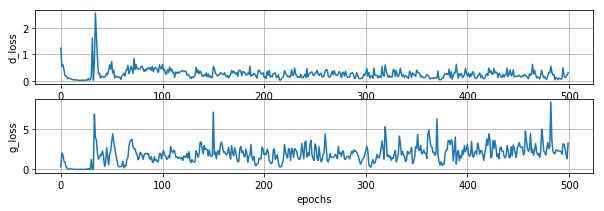

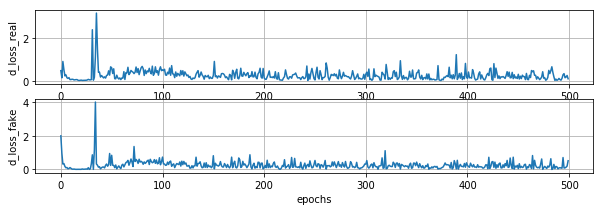

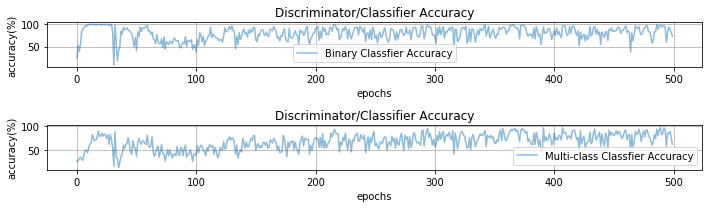

In [469]:
plot(500, sgan2.epoches_list, sgan2.dis_loss, sgan2.dis_loss_real,sgan2.dis_loss_fake, sgan2.gen_loss, sgan2.sgan_loss, sgan2.d_binary_acc, sgan2.d_classes_acc)

### Experiment test 3:  10.19-SGAN 800, 100 Labelled examples, 50 normal cars, 50 randomly selected outliers.
- Learning rate: G - 0.0004, D: 0.0002, combinded: 0.0002
- Result Analysis: Not Good
    - Model D/C is evaluated by using test dataset from 1000 labelled examples version, not from the same distribution. Therefore, the accuracy of test set is not reliable.
    - 

In [412]:
start = timeit.default_timer()
sgan3 = SGAN()
sgan3.train(x_train, y_train, epochs=800, batch_size=64, save_interval=50)
end = timeit.default_timer()

1.Build and compile the discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_297 (Conv2D)          (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_153 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_174 (Dropout)        (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_298 (Conv2D)          (None, 16, 16, 128)       204928    
_________________________________________________________________
zero_padding2d_39 (ZeroPaddi (None, 17, 17, 128)       0         
_________________________________________________________________
batch_normalization_259 (Bat (None, 17, 17, 128)       512       
_________________________________________________________________
leaky_re_lu_154 (LeakyReLU)  (None, 17

In [464]:
validity = np.ones((x_test.shape[0],),dtype='int').T
class_labels = to_categorical(y_test, num_classes = 2+1)
#validity_labels = to_categorical(validity, num_classes = 2+1)

loss_and_metrics = sgan3.discriminator.evaluate(x_test,[validity, class_labels], batch_size=20)
# loss_and_metrics = model.evaluate(x_test, y_test, batch_size=128)
# classes = model.predict(x_test, batch_size=128)

200/200 [==============================] - 1s     


In [465]:
print(loss_and_metrics)
sgan3.discriminator.metrics_names

[3.9344701766967773, 3.9655018091201781, 3.9034385442733766, 0.10999999903142452, 0.15000000372529029]


['loss',
 'Binary_Dense_loss',
 'Classes_Dense_loss',
 'Binary_Dense_acc',
 'Classes_Dense_acc']

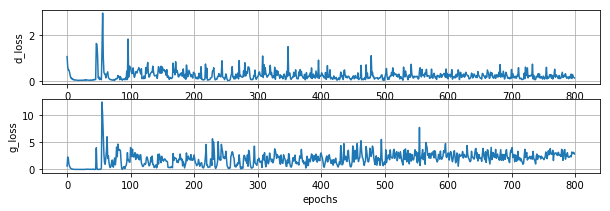

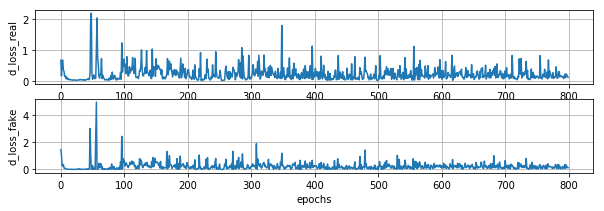

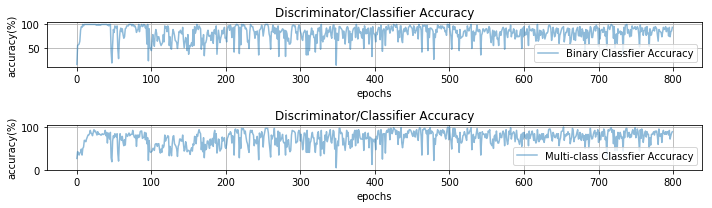

In [470]:
plot(500, sgan3.epoches_list, sgan3.dis_loss, sgan3.dis_loss_real,sgan3.dis_loss_fake, sgan3.gen_loss, sgan3.sgan_loss, sgan3.d_binary_acc, sgan3.d_classes_acc)

## Experiment test 4: 10.22. SGAN epoches 650, 1000 labelled examples 
- Dataset: 1000 labelled examples
    - 550 normal cars, 
    - 450 outliers
        - 50 black image
        - 50 exposed image (high brightness)
        - 50 blurry image
        - 50 incomplete car image
        - 50 street/road/house image
        - 200 otherside image
            - 50 backside
            - 50 leftside
            - 50 rightside
            - 50 inside
    - Train set examples: $440 + 360 = 800$
    - Test set examples: $360 + 90 = 200$
- LR: 0.0002
- Learning rate: G - 0.0004, D: 0.0002, combinded: 0.0004
- Result Analysis:
     - classifier accuracy: $68.5\%$

In [461]:
start = timeit.default_timer()
sgan4 = SGAN()
sgan4.train(x_train, y_train, epochs=650, batch_size=64, save_interval=50)
end = timeit.default_timer()

1.Build and compile the discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_321 (Conv2D)          (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_165 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_189 (Dropout)        (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_322 (Conv2D)          (None, 16, 16, 128)       204928    
_________________________________________________________________
zero_padding2d_42 (ZeroPaddi (None, 17, 17, 128)       0         
_________________________________________________________________
batch_normalization_280 (Bat (None, 17, 17, 128)       512       
_________________________________________________________________
leaky_re_lu_166 (LeakyReLU)  (None, 17

#### Plot training process

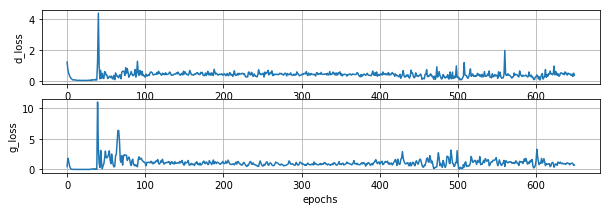

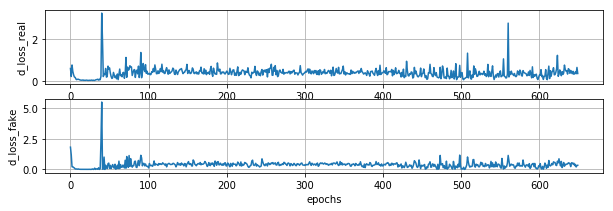

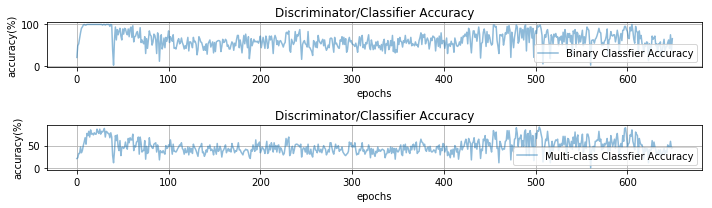

In [468]:
plot(650, sgan4.epoches_list, sgan4.dis_loss, sgan4.dis_loss_real,sgan4.dis_loss_fake, sgan4.gen_loss, sgan4.sgan_loss, sgan4.d_binary_acc, sgan4.d_classes_acc)

### Evaluating Discriminator/Classifier via using test data (Evaluation Including $Class$ $2:FAKE$)

In [476]:
validity = np.ones((x_test.shape[0],),dtype='int').T
class_labels = to_categorical(y_test, num_classes = 2+1)
#validity_labels = to_categorical(validity, num_classes = 2+1)

loss_and_metrics4 = sgan4.discriminator.evaluate(x_test,[validity, class_labels], batch_size=20)
# classes = model.predict(x_test, batch_size=128)
print('Discriminator/Classifier loss: %f \nDiscriminiator Accuracy: %.2f%% \nClassfier Accuracy: %.2f%%'%(loss_and_metrics4[0], 100*loss_and_metrics4[3], 100*loss_and_metrics4[4]))
#sgan4.discriminator.metrics_names

200/200 [==============================] - 1s     
Discriminator/Classifier loss: 0.729244 
Discriminiator Accuracy: 66.00% 
Classfier Accuracy: 68.50%


### Evaluate Classifier (Excluding $ Class$ $2: FAKE$)
- Only calculate accuracy of true data
    - $Class$ $0$: normal cars
    - $Class$ $1$: outliers

In [496]:
real_fake_label_4, classes_with_fake_4 = sgan4.discriminator.predict(x_test, batch_size=20)
acc4 = calculate_data_accuracy_without_fake(classes_with_fake_4, y_test)
print(acc4)

Accuracy of true data: 78.74%


In [447]:
classes = sgan4.discriminator.predict(x_test, batch_size=20)
print(len(classes[1]))
print(str(classes))

200


### Experiment Test 5: 10.22 - 1000 labelled examples, SGAN Epoches 1000
- Hyperparamaters Setting:
    - Learning Rate: G: 0.0004, D: 0.0002, Combind: 0.0004
    - batch size : 64
- Result Analysis: 
    - Loss of D/C: $0.584517$
    - Discriminator Accuracy: $80.5\%$
    - Classifier Accuracy: $74.5\%$
    - Accuracy of true data (**not consider** true data predicted as $Class$ $FAKE$): $80.98\%$

In [473]:
start = timeit.default_timer()
sgan5 = SGAN()
sgan5.train(x_train, y_train, epochs=1000, batch_size=64, save_interval=50)
end = timeit.default_timer()

1.Build and compile the discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_329 (Conv2D)          (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_169 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_194 (Dropout)        (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_330 (Conv2D)          (None, 16, 16, 128)       204928    
_________________________________________________________________
zero_padding2d_43 (ZeroPaddi (None, 17, 17, 128)       0         
_________________________________________________________________
batch_normalization_287 (Bat (None, 17, 17, 128)       512       
_________________________________________________________________
leaky_re_lu_170 (LeakyReLU)  (None, 17

In [480]:
elapsed_time(end-start)

Elapsed 3.7830814747hour


### Evaluating Discriminator/Classifier via using test data (Evaluation Including $Class$ $2:FAKE$)

In [478]:
validity = np.ones((x_test.shape[0],),dtype='int').T
class_labels = to_categorical(y_test, num_classes = 2+1)

loss_and_metrics5 = sgan5.discriminator.evaluate(x_test,[validity, class_labels], batch_size=20)
print('Discriminator/Classifier loss: %f \nDiscriminiator Accuracy: %.2f%% \nClassfier Accuracy: %.2f%%'%(loss_and_metrics5[0], 100*loss_and_metrics5[3], 100*loss_and_metrics5[4]))
# print(loss_and_metrics5)
# sgan5.discriminator.metrics_names

200/200 [==============================] - 1s     
Discriminator/Classifier loss: 0.584517 
Discriminiator Accuracy: 80.50% 
Classfier Accuracy: 74.50%


### Evaluate Classifier (Excluding $ Class$ $2: FAKE$)
- Only calculate accuracy of true data
    - $Class$ $0$: normal cars
    - $Class$ $1$: outliers

In [495]:
real_fake_label_5, classes_with_fake_5 = sgan5.discriminator.predict(x_test, batch_size=20)
acc5 = calculate_data_accuracy_without_fake(classes_with_fake_5, y_test)
print(acc5)

Accuracy of true data: 80.98%


### Predict Test

In [ ]:
# classes = model.predict(x_test, batch_size=128)

### Experiment Test 6: 10.23 - 1000 labelled examples, SGAN Epoches 2000
- batch size: 128

In [ ]:
start = timeit.default_timer()
sgan6 = SGAN()
sgan6.train(x_train, y_train, epochs=2000, batch_size=64, save_interval=50)
end = timeit.default_timer()

#### Implementation2. SGAN epoches 2000
- Learning rate：0.0002
- G, D, G&D use same optimizer
- optimizer: Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [243]:
sgan_1 = SGAN()
start = timeit.default_timer()
sgan_1.train(x_train, y_train, epochs=2000, batch_size=32, save_interval=50)
end = timeit.default_timer()

1.Build and compile the discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_225 (Conv2D)          (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_117 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_129 (Dropout)        (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_226 (Conv2D)          (None, 16, 16, 128)       204928    
_________________________________________________________________
zero_padding2d_30 (ZeroPaddi (None, 17, 17, 128)       0         
_________________________________________________________________
batch_normalization_196 (Bat (None, 17, 17, 128)       512       
_________________________________________________________________
leaky_re_lu_118 (LeakyReLU)  (None, 17

Epoch 1000: [Discriminator/Classifier loss: 0.250006, Discriminator_acc: 81.25%, Classifier_acc: 87.50%] [Generator loss: 3.286988]
Epoch 1050: [Discriminator/Classifier loss: 0.373665, Discriminator_acc: 81.25%, Classifier_acc: 65.62%] [Generator loss: 2.281129]
Epoch 1100: [Discriminator/Classifier loss: 0.108923, Discriminator_acc: 96.88%, Classifier_acc: 96.88%] [Generator loss: 3.513971]
Epoch 1150: [Discriminator/Classifier loss: 0.090589, Discriminator_acc: 93.75%, Classifier_acc: 90.62%] [Generator loss: 3.783548]
Epoch 1200: [Discriminator/Classifier loss: 0.063487, Discriminator_acc: 96.88%, Classifier_acc: 100.00%] [Generator loss: 4.400401]
Epoch 1250: [Discriminator/Classifier loss: 0.287101, Discriminator_acc: 71.88%, Classifier_acc: 75.00%] [Generator loss: 5.412862]
Epoch 1300: [Discriminator/Classifier loss: 0.030960, Discriminator_acc: 100.00%, Classifier_acc: 93.75%] [Generator loss: 3.502134]
Epoch 1350: [Discriminator/Classifier loss: 0.140246, Discriminator_acc: 9

In [251]:
l = range(2000)
x = l[0::5]

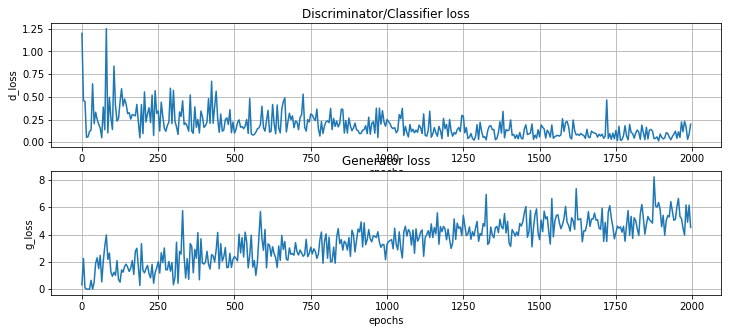

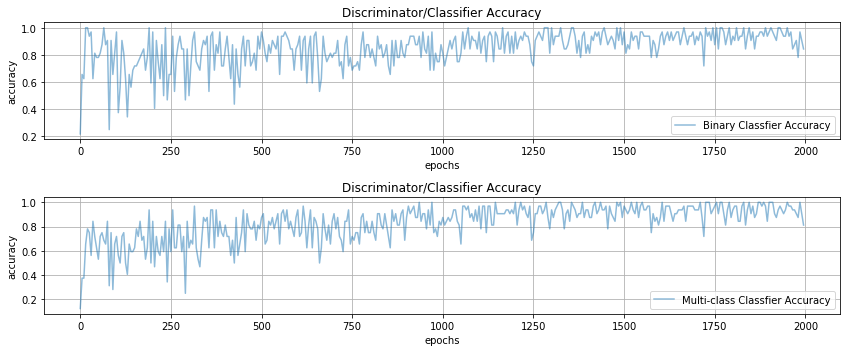

In [276]:
plot(2000, x, sgan_1.dis_loss, sgan_1.gen_loss, sgan_1.d_binary_acc, sgan_1.d_classes_acc)

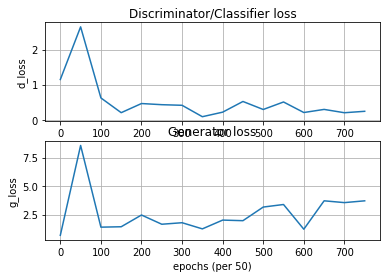

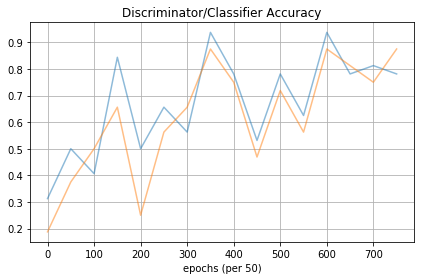

In [240]:
x = [0,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750]
d_loss = [1.1466, 2.649109, 0.620925, 0.200368, 0.460990, 0.428126, 0.410835, 0.085274, 0.214923, 0.519703, 0.291219, 0.505386, 0.204581, 0.293442, 0.198557, 0.239489]
g_loss = [0.690435, 8.559340, 1.403960, 1.439888, 2.467533, 1.660146, 1.792909, 1.253919, 2.022333, 1.971465, 3.164767, 3.387980, 1.225002, 3.711246, 3.553851, 3.710154]
d_binary_acc = [0.3125, 0.5, 0.4062, 0.8438, 0.5, 0.6562, 0.5625, 0.9375, 0.7812, 0.5312, 0.7812, 0.625, 0.9375, 0.7812, 0.8125, 0.7812]
d_classes_acc = [0.1875,0.375, 0.5, 0.6562, 0.25,0.5625, 0.6562, 0.875, 0.75, 0.4688, 0.7188, 0.5625, 0.875, 0.8125, 0.75, 0.875]
plot(800, x, d_loss, g_loss, d_binary_acc, d_classes_acc)

In [238]:
def plot(epoches, x, d_loss, g_loss, d_binary_acc, d_classes_acc):
    plt.figure(1) # plot with various axes scales
    #plt.figsize=(20,20)
    
    # d_loss
    plt.subplot(2,1, 1)
    plt.plot(x, d_loss)
    plt.ylabel('d_loss')
    plt.xlabel('epochs (per 50)')
    plt.title("Discriminator/Classifier loss")
    plt.grid(True)
    
    # g_loss
    plt.subplot(2,1, 2)
    plt.plot(x, g_loss)
    plt.ylabel('g_loss')
    plt.xlabel('epochs (per 50)')
    plt.title("Generator loss")
    plt.grid(True)
    
    plt.figure(2) # plot with various axes scales
    # Binary acc
    plt.subplot(1,1,1)
    plt.plot(x, d_binary_acc, label = 'Binary Accuracy' , alpha = 0.5)
    plt.plot(x, d_classes_acc, label = 'Classes Accuracy' , alpha = 0.5 )
    plt.xlabel('epochs (per 50)')
    plt.title("Discriminator/Classifier Accuracy")
    plt.grid(True)
    
    plt.subplots_adjust(hspace=0.5)
    
    plt.tight_layout()
    plt.show()
    

#### Epoches 800, Updated G and D
- Updated sequence of BN, Activation, Dropout in G and D
- Learning rate: 0.0002 for Generator, Discriminator and Combinded model.

In [104]:
sgan1 = SGAN()
start = timeit.default_timer()
sgan1.train(x_train, y_train, epochs=800, batch_size=32, save_interval=50)
end = timeit.default_timer()

1.Build and compile the discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_153 (Conv2D)          (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_77 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 16, 16, 128)       204928    
_________________________________________________________________
zero_padding2d_20 (ZeroPaddi (None, 17, 17, 128)       0         
_________________________________________________________________
batch_normalization_134 (Bat (None, 17, 17, 128)       512       
_________________________________________________________________
leaky_re_lu_78 (LeakyReLU)   (None, 17

### Predict Function: Use Discriminator/Classfier of SGAN to do Image Classification

In [406]:
def predict_car(sgan,image):
#    my_image = scipy.misc.imresize(image, size=(64,64))
    plt.imshow(image)
    plt.show()

    img_array = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64, 64, 3))

    # Normalize to -1 to 1
    img_array = (img_array.astype(np.float32) - 127.5) / 127.5
    p = sgan.discriminator.predict(img_array)
    print(p)
    
    #Suppress Scientific Notation in Numpy
    np.set_printoptions(suppress=True)  
    
    probabilities = sgan.discriminator.predict(img_array)
    
    class_probabilities = probabilities[1][0]
    normal_prob = class_probabilities[0]
    outlier_prob = class_probabilities[1]
    if normal_prob > outlier_prob:
        print("Satisfied: normal cars")
    else:
        print("Unsatisfied picture.")
    
#    r_f_prediction = [float(round(x)) for x in probabilities[0]][0]
#     if r_f_prediction == 1.0:
#         r_f_prediction_class = "real"
#     else: 
#         r_f_prediction_class = "fake"
       
#     class_plus_labels = ["normal cars", "outliers", "fake"]  # N+1 labels
#     classes_probabilities = probabilities[1][0].tolist()
#     print(classes_probabilities)
#     class_index = classes_probabilities.index(max(classes_probabilities))
#     print(class_index)
#     class_prediction = class_plus_labels[class_index]
#     result = "This image is " +r_f_prediction_class + ".\nClass: " + class_prediction 
#     print(result) 

### Test with unlearned images provided by car washers

Predict images from provided data:


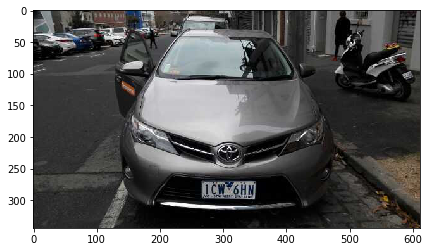

[array([[ 0.4515]], dtype=float32), array([[ 0.7951,  0.0182,  0.1867]], dtype=float32)]
Satisfied: normal cars


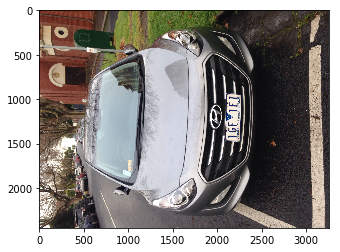

[array([[ 0.0099]], dtype=float32), array([[ 0.0234,  0.0153,  0.9613]], dtype=float32)]
Satisfied: normal cars


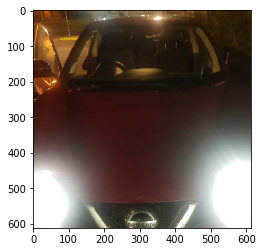

[array([[ 0.0697]], dtype=float32), array([[ 0.1229,  0.0286,  0.8485]], dtype=float32)]
Satisfied: normal cars


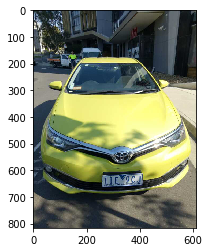

[array([[ 0.0179]], dtype=float32), array([[ 0.0007,  0.0111,  0.9882]], dtype=float32)]
Unsatisfied picture.


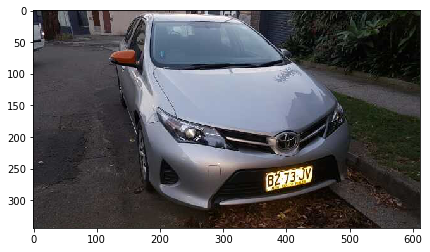

[array([[ 0.8614]], dtype=float32), array([[ 0.9064,  0.0211,  0.0725]], dtype=float32)]
Satisfied: normal cars


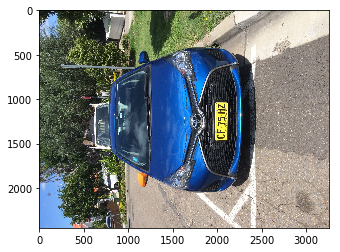

[array([[ 0.9637]], dtype=float32), array([[ 0.9239,  0.0447,  0.0314]], dtype=float32)]
Satisfied: normal cars


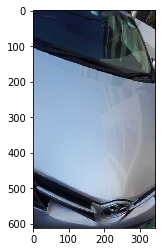

[array([[ 0.825]], dtype=float32), array([[ 0.002 ,  0.8355,  0.1624]], dtype=float32)]
Unsatisfied picture.


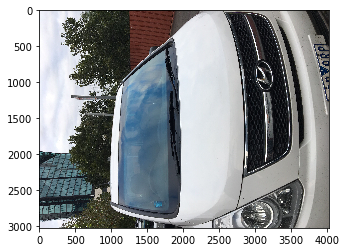

[array([[ 0.0071]], dtype=float32), array([[ 0.0026,  0.0229,  0.9745]], dtype=float32)]
Unsatisfied picture.


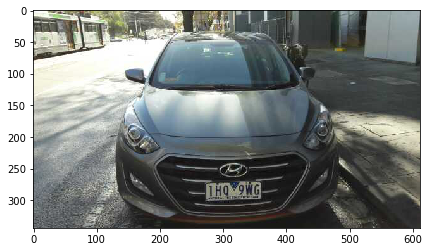

[array([[ 0.5004]], dtype=float32), array([[ 0.6786,  0.0119,  0.3095]], dtype=float32)]
Satisfied: normal cars


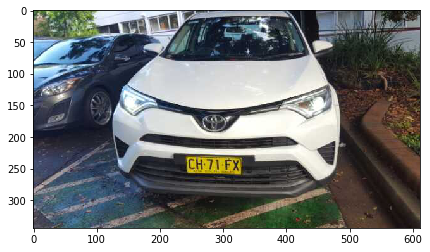

[array([[ 0.0046]], dtype=float32), array([[ 0.072 ,  0.0057,  0.9223]], dtype=float32)]
Satisfied: normal cars


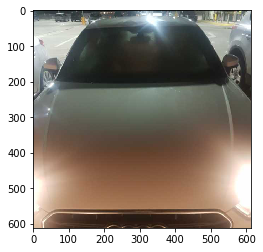

[array([[ 0.8727]], dtype=float32), array([[ 0.0198,  0.8578,  0.1224]], dtype=float32)]
Unsatisfied picture.


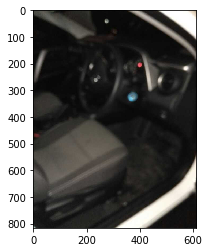

[array([[ 0.7601]], dtype=float32), array([[ 0.0182,  0.7787,  0.2032]], dtype=float32)]
Unsatisfied picture.


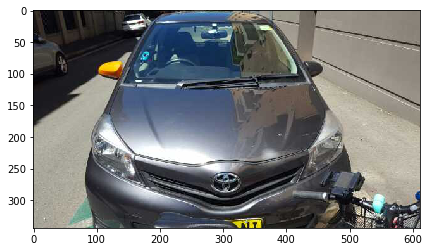

[array([[ 0.8298]], dtype=float32), array([[ 0.867 ,  0.0226,  0.1103]], dtype=float32)]
Satisfied: normal cars


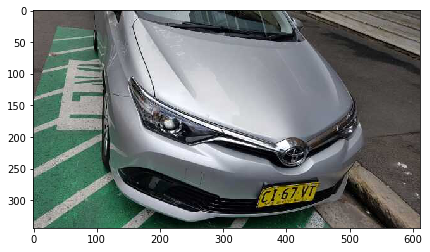

[array([[ 0.1932]], dtype=float32), array([[ 0.7094,  0.0024,  0.2882]], dtype=float32)]
Satisfied: normal cars


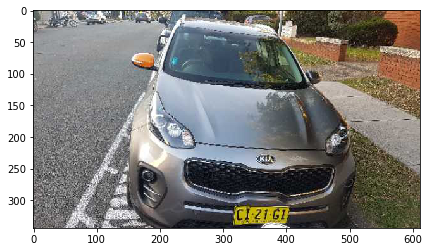

[array([[ 0.0448]], dtype=float32), array([[ 0.1284,  0.0055,  0.8661]], dtype=float32)]
Satisfied: normal cars


In [407]:
import scipy
from skimage import io
from scipy import ndimage

img_urls = ["https://tookan.s3.amazonaws.com/task_images/EB4X1498012839565-TOOKAN21062017124038.jpg",
            "https://tookan.s3.amazonaws.com/task_images/v75N1498001792601-photoName.jpeg",
            "https://tookan.s3.amazonaws.com/task_images/v0K61498464992064-TOOKAN26062017061631.jpg",
            "https://tookan.s3.amazonaws.com/task_images/ybVT1491437071120-TOOKAN06042017100428.jpg",
            "https://tookan.s3.amazonaws.com/task_images/qVlt1487532794972-TOOKAN20022017063311.jpg",
            "https://tookan.s3.amazonaws.com/task_images/p0eg1487642868361-photoName.jpeg",
            "https://tookan.s3.amazonaws.com/task_images/OfaQ1500541656425-TOOKAN20072017035351.jpg",
           "https://tookan.s3.amazonaws.com/task_images/RvJ21493793034122-photoName.jpeg",
           "https://tookan.s3.amazonaws.com/task_images/ZJyL1496194239293-TOOKAN31052017113038.jpg",
           "https://tookan.s3.amazonaws.com/task_images/6tD91488406242311-TOOKAN02032017091033.jpg",
            "https://tookan.s3.amazonaws.com/task_images/D5Ns1500028894670-TOOKAN14072017084133.jpg",
           "https://tookan.s3.amazonaws.com/task_images/vxBj1498636362559-TOOKAN28062017055241.jpg",
          "https://tookan.s3.amazonaws.com/task_images/mYhY1487569424559-TOOKAN20022017014352.jpg",
          "https://tookan.s3.amazonaws.com/task_images/LWZK1487115774919-TOOKAN15022017103452.jpg",
          "https://tookan.s3.amazonaws.com/task_images/lXiv1496124949094-TOOKAN30052017041547.jpg",]

print("Predict images from provided data:")
for url in img_urls:
    image = io.imread(url)
    predict_car(sgan2,image)

### Test with unlearned images search from online

Predict Images find from online:


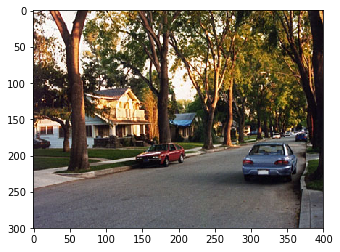

[array([[ 0.0145]], dtype=float32), array([[ 0.0493,  0.0314,  0.9192]], dtype=float32)]
Satisfied: normal cars


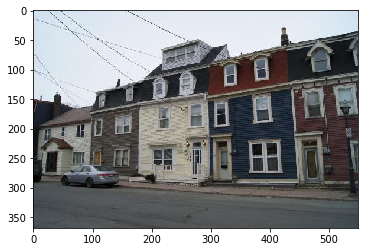

[array([[ 0.0721]], dtype=float32), array([[ 0.0286,  0.1814,  0.7899]], dtype=float32)]
Unsatisfied picture.


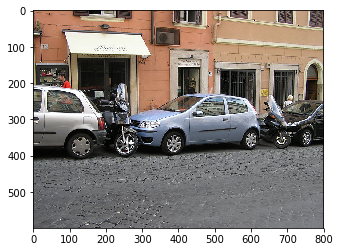

[array([[ 0.1037]], dtype=float32), array([[ 0.0468,  0.1682,  0.785 ]], dtype=float32)]
Unsatisfied picture.


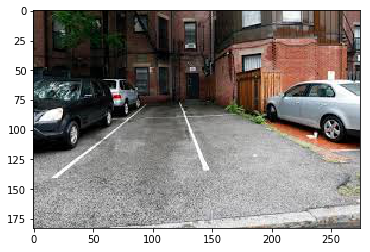

[array([[ 0.1659]], dtype=float32), array([[ 0.0006,  0.7086,  0.2907]], dtype=float32)]
Unsatisfied picture.


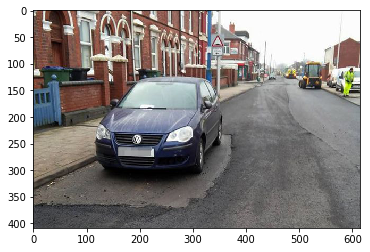

[array([[ 0.424]], dtype=float32), array([[ 0.2309,  0.1849,  0.5842]], dtype=float32)]
Satisfied: normal cars


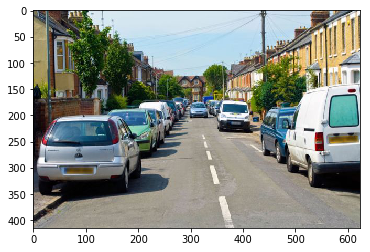

[array([[ 0.0123]], dtype=float32), array([[ 0.0052,  0.0334,  0.9614]], dtype=float32)]
Unsatisfied picture.


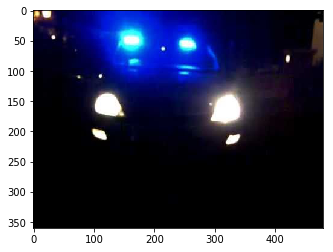

[array([[ 0.3274]], dtype=float32), array([[ 0.0886,  0.5124,  0.3989]], dtype=float32)]
Unsatisfied picture.


In [404]:
print("Predict Images find from online:")
my_imgs = ["houseOnStreet.jpg","gower-house-is-now-painted.jpg",
           "car_in_street2.jpg","1.jpeg","car.jpg","road.jpg", "car_night.jpg"]
for my_img in my_imgs:
    #my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
    fname = "online_pic_for_predict/" + my_img
    my_image = np.array(ndimage.imread(fname, flatten=False))
    predict_car(sgan2,my_image)    